# Notebook 

In [88]:
import pandas as pd
from scipy.signal import medfilt
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt, timezone as tz
from sklearn.linear_model import LinearRegression


In [2]:
# Loading data
df_weiss = pd.read_csv('../data/fuellstandsensoren-glassammelstellen-weissglas.csv',sep=';')
df_gruen = pd.read_csv('../data/fuellstandsensoren-glassammelstellen-gruenglas.csv',sep=';')
df_braun = pd.read_csv('../data/fuellstandsensoren-glassammelstellen-braunglas.csv',sep=';')

df_weiss = df_weiss[['measured_at','data_distance','geo_point_2d','device_id']]
df_gruen = df_gruen[['measured_at','data_distance','geo_point_2d','device_id']]
df_braun = df_braun[['measured_at','data_distance','geo_point_2d','device_id']]

df_weiss['color'] = 'weiss'
df_gruen['color'] = 'gruen'
df_braun['color'] = 'braun'

df = pd.concat([df_weiss,df_braun,df_gruen])


In [13]:
# Data cleaning
df.dropna(subset=['data_distance'],inplace=True)
df = df[df['data_distance'] != 2500]
df = df[df['data_distance'] != 300]
df['datetime'] = pd.to_datetime(df['measured_at'])
df['seconds'] = df['datetime'].apply(lambda x: dt.timestamp(x))
df.sort_values(by=['datetime'],inplace=True)

/tmp/ipykernel_168866/1092167986.py:5: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['datetime'] = pd.to_datetime(df['measured_at'])


In [10]:
dev_df = pd.DataFrame(columns=['device_id','max_val','min_val','max_capacity'])
for dev_id in set(df['device_id'].values):
    estimates = medfilt(df[df['device_id'] == dev_id]['data_distance'],kernel_size=11)
    dev_df = pd.concat((dev_df,pd.DataFrame({'device_id':dev_id,'max_val':np.max(estimates),'min_val':np.min(estimates),'max_capacity':np.max(estimates)-np.min(estimates)},index=[0])),ignore_index=True)


/tmp/ipykernel_168866/4113225383.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dev_df = pd.concat((dev_df,pd.DataFrame({'device_id':dev_id,'max_val':np.max(estimates),'min_val':np.min(estimates),'max_capacity':np.max(estimates)-np.min(estimates)},index=[0])),ignore_index=True)


In [93]:
dev_fuellraten = pd.DataFrame(columns=['device_id','interval_start','interval_end','fuellrate','median_time','min_val','glass_color','fill_percentage','fuellrate_percentage_per_day'])
for device_id in set(df['device_id'].values):
    device_df = df[df['device_id'] == device_id]
    color = device_df['color'].values[0]
    estimates = medfilt(device_df['data_distance'].values,kernel_size=21)
    min_fill = dev_df[dev_df['device_id'] == device_id]['min_val'].values[0]
    max_fill = dev_df[dev_df['device_id'] == device_id]['max_val'].values[0]

    changes = estimates[2:] - estimates[:-2]
    last_change = 0
    last_change_time = np.min(device_df['datetime'])
    for idx, change in enumerate(changes):
        if change > 400 and idx-last_change > 10:
            change_time = device_df['datetime'].values[idx]
            interval = device_df.iloc[last_change:idx]
            last_change = idx
            min_val = min(interval['data_distance'])
            fill_percentage = (max_fill-min_val)/(max_fill-min_fill)
            median_dt = dt.fromtimestamp(np.median(interval['seconds']))
            reg = LinearRegression().fit(interval['seconds'].values.reshape(-1,1),interval['data_distance'])
            fuellrate = -reg.coef_[0] * 60*60

            fuellrate_percentage_per_day = fuellrate*24/(max_fill-min_fill)
            dev_fuellrate = pd.DataFrame({'device_id':device_id,'interval_start':last_change_time, 'interval_end':change_time,'fuellrate':fuellrate,'median_time':median_dt,'min_val': min_val,'glass_color':color,'fuellrate_percentage_per_day':fuellrate_percentage_per_day,'fill_percentage':fill_percentage},index=[0])
            last_change_time = change_time
            #print(dev_fuellrate)
            dev_fuellraten = pd.concat((dev_fuellraten,dev_fuellrate),ignore_index=True)


/tmp/ipykernel_168866/3581104385.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dev_fuellraten = pd.concat((dev_fuellraten,dev_fuellrate),ignore_index=True)


/home/clebek/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


device_id
04c14b60-34a4-40ab-aae2-bf4d616eb0d6    Axes(0.125,0.2;0.775x0.68)
0b011106-e5fe-4202-92bd-c89abd042249    Axes(0.125,0.2;0.775x0.68)
11d4bcfe-bde2-42bd-8ebc-43ee77012480    Axes(0.125,0.2;0.775x0.68)
134fc269-ec25-466f-82e7-780beb314108    Axes(0.125,0.2;0.775x0.68)
1607ca61-c966-483d-bbfb-d97027d507c1    Axes(0.125,0.2;0.775x0.68)
18def07f-6077-4543-a572-982cd63ef262    Axes(0.125,0.2;0.775x0.68)
195f9fb4-4486-4b3d-bb41-8a9d7715a931    Axes(0.125,0.2;0.775x0.68)
1e8d1b09-d186-495e-bd1f-cb06afdd5b21    Axes(0.125,0.2;0.775x0.68)
286bb721-9cb2-448a-9c2f-aadd4a1bf2d6    Axes(0.125,0.2;0.775x0.68)
2a508d99-73fc-4992-8de0-f452a979f047    Axes(0.125,0.2;0.775x0.68)
2e4a8f6d-d398-4749-bc74-a24efa3f5644    Axes(0.125,0.2;0.775x0.68)
2e98f08e-3cfb-4594-9f9c-133fab16f7ca    Axes(0.125,0.2;0.775x0.68)
3301af3b-a6fe-429e-8b01-c7b71249abdf    Axes(0.125,0.2;0.775x0.68)
36816c9e-3b69-4b8c-b9f7-150b0edf94db    Axes(0.125,0.2;0.775x0.68)
3dd2b101-9f8d-41fa-9dc3-823729aefabb    Axes(0.125,0

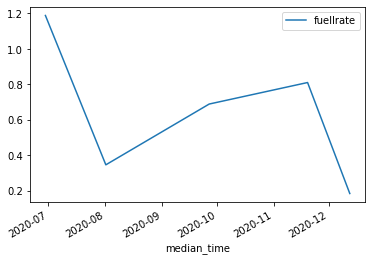

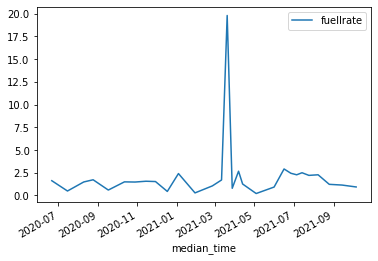

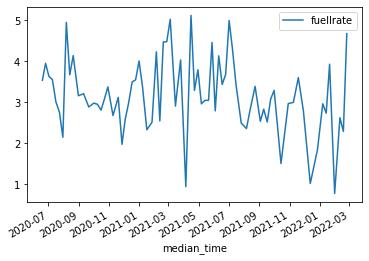

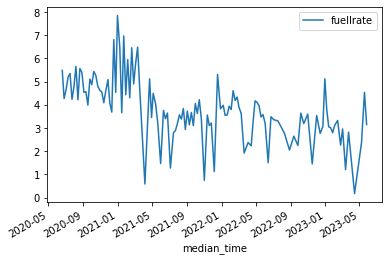

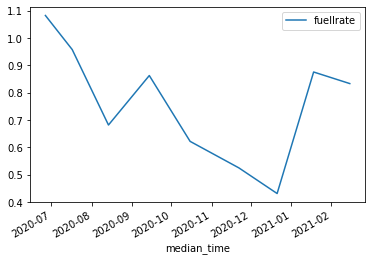

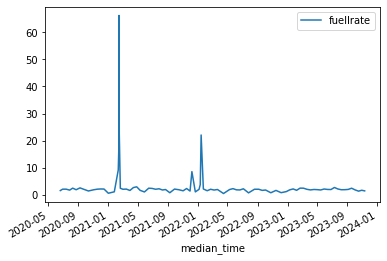

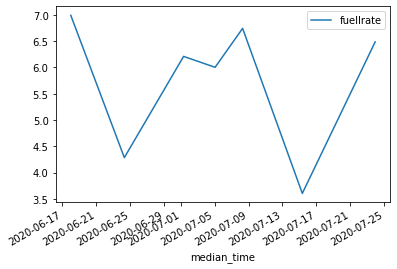

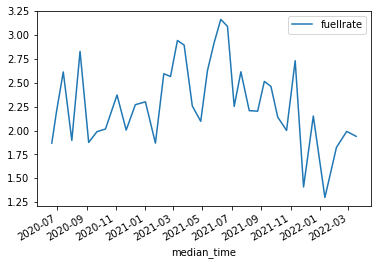

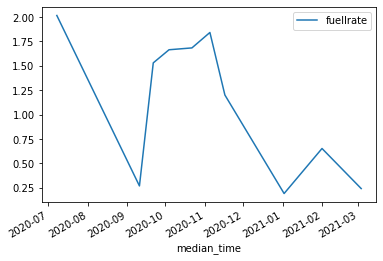

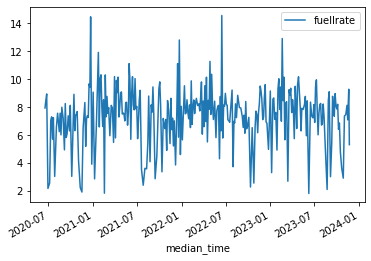

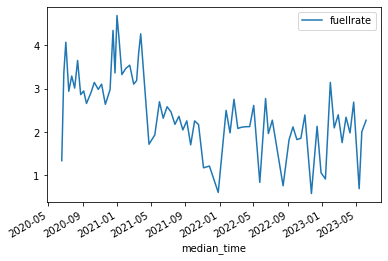

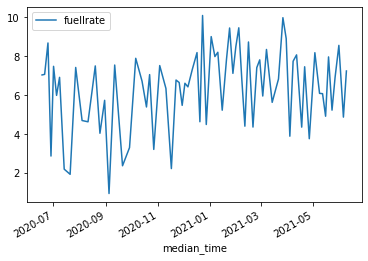

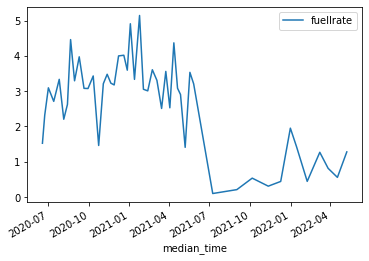

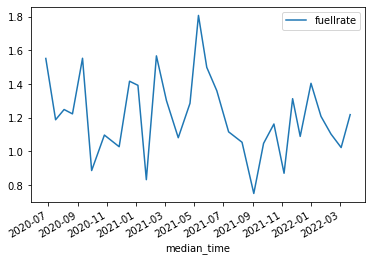

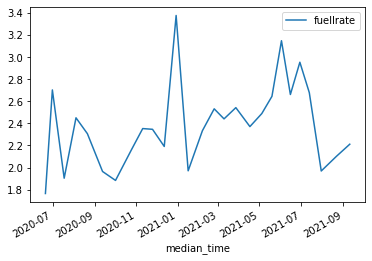

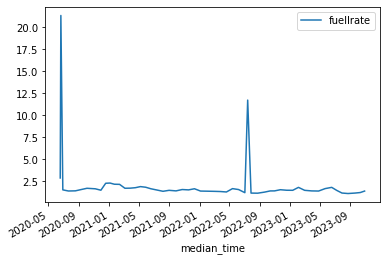

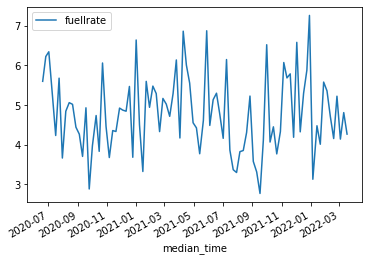

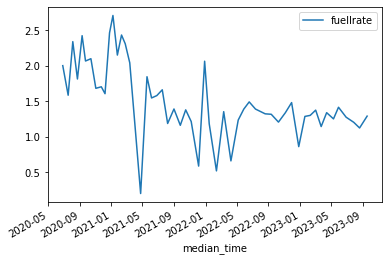

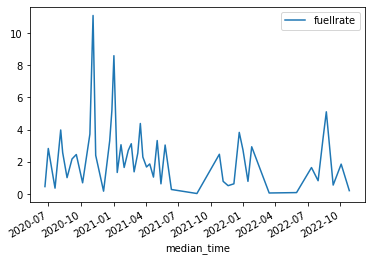

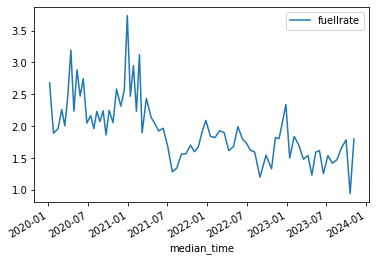

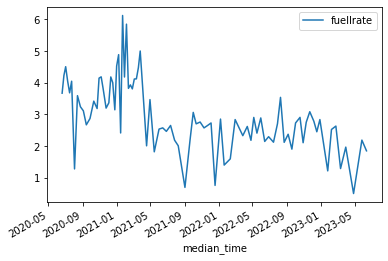

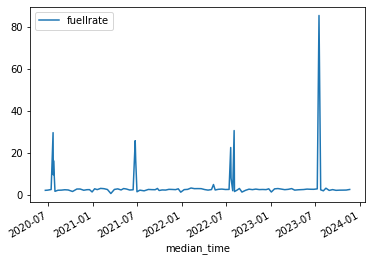

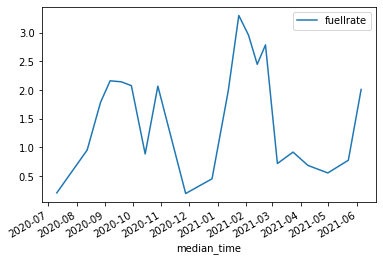

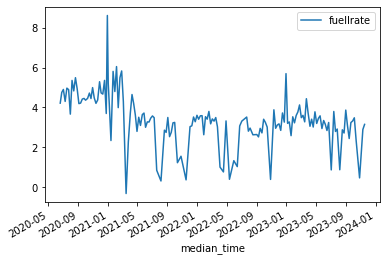

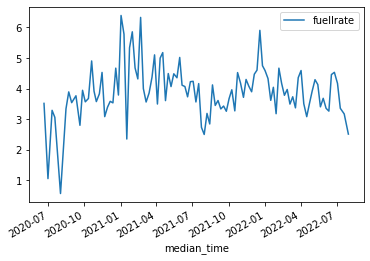

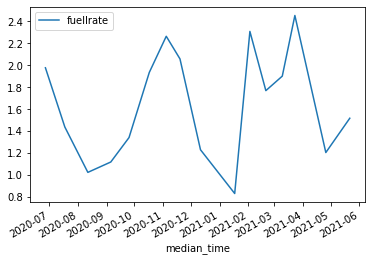

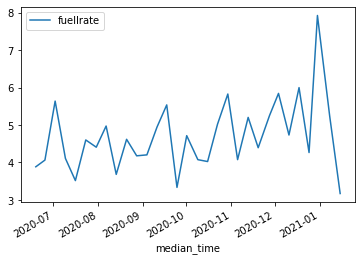

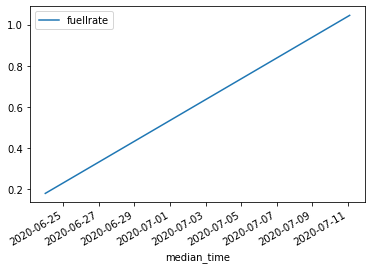

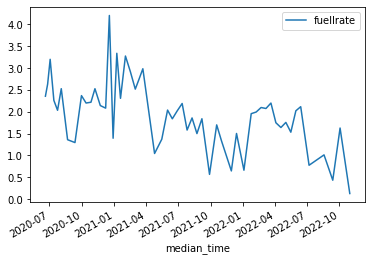

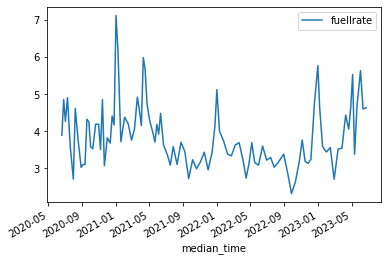

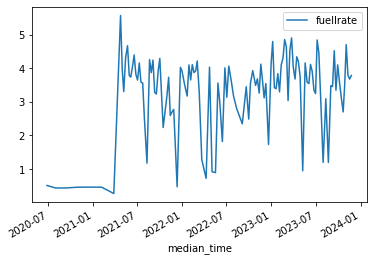

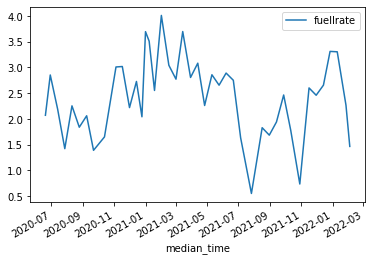

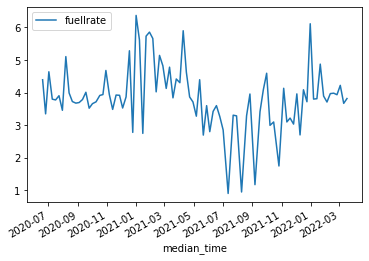

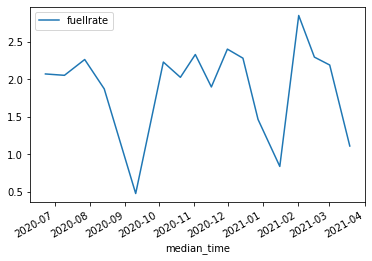

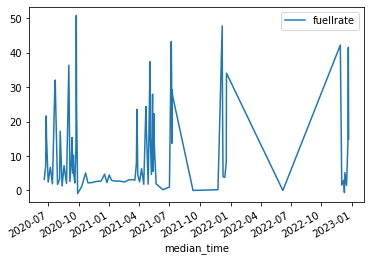

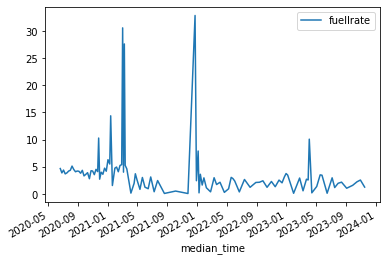

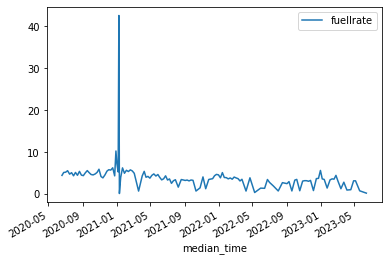

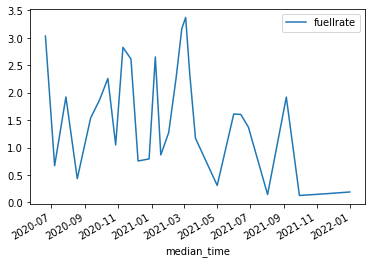

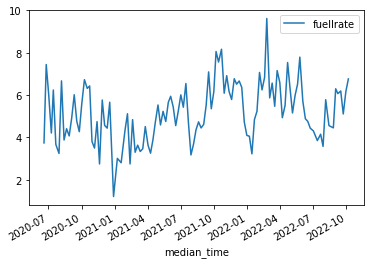

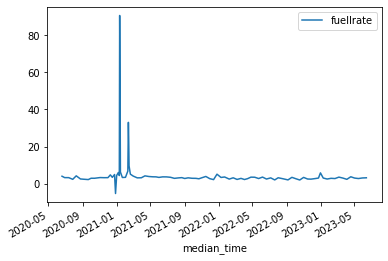

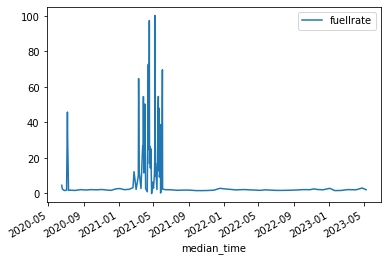

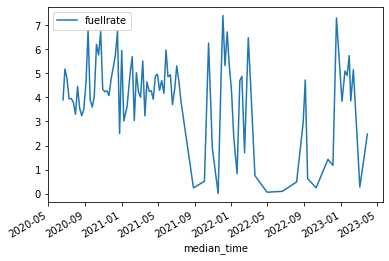

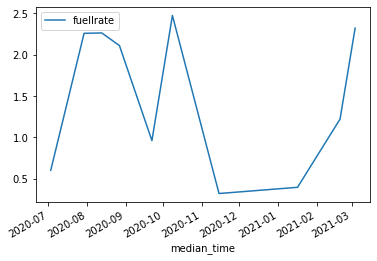

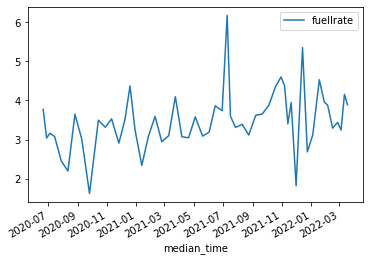

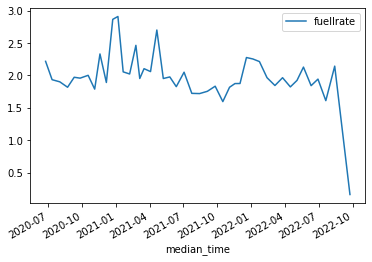

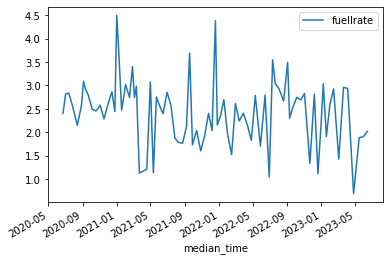

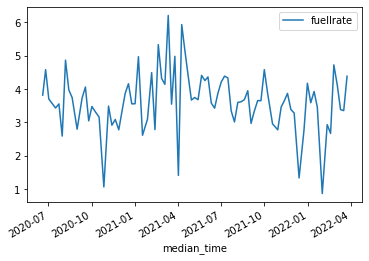

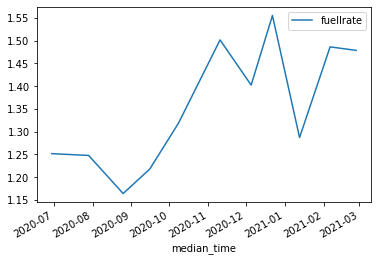

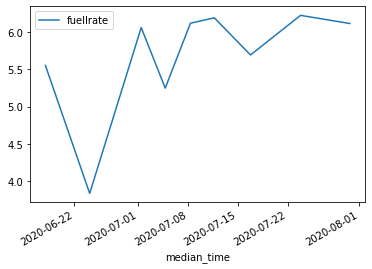

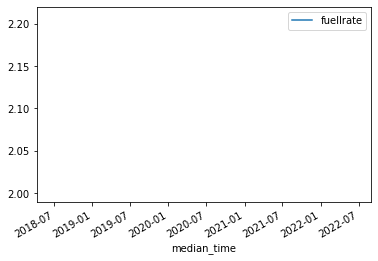

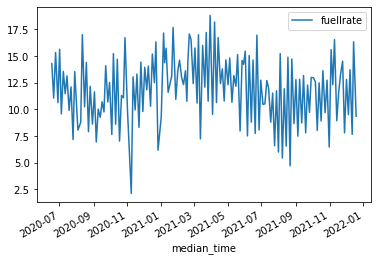

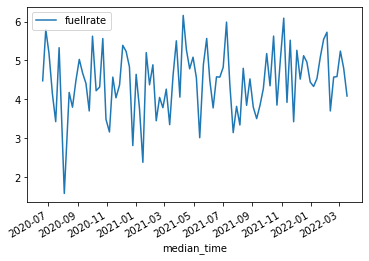

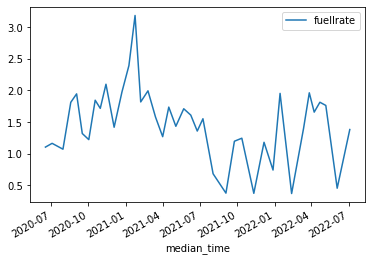

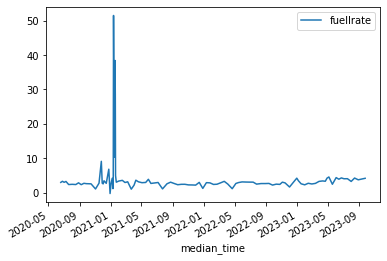

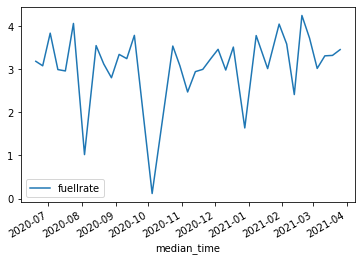

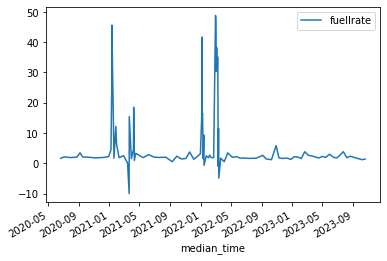

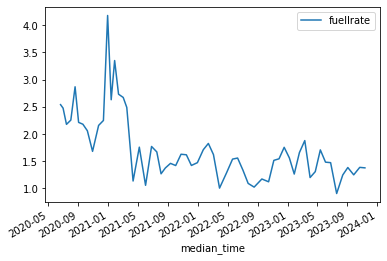

In [77]:
dev_fuellraten.groupby('device_id').plot(x='median_time',y='fuellrate',legend='device_id')

(array([18444., 18506., 18567., 18628., 18687., 18748., 18809., 18871.]),
 [Text(18444.0, 0, '2020-07'),
  Text(18506.0, 0, '2020-09'),
  Text(18567.0, 0, '2020-11'),
  Text(18628.0, 0, '2021-01'),
  Text(18687.0, 0, '2021-03'),
  Text(18748.0, 0, '2021-05'),
  Text(18809.0, 0, '2021-07'),
  Text(18871.0, 0, '2021-09')])

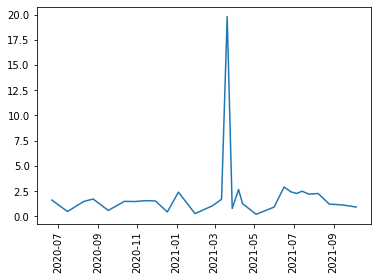

In [81]:
device_id = '0b011106-e5fe-4202-92bd-c89abd042249'
d_df = dev_fuellraten[dev_fuellraten['device_id'] == device_id]
plt.plot(d_df['median_time'],d_df['fuellrate'])
plt.xticks(rotation='vertical')

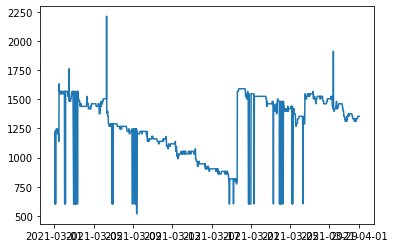

In [92]:
tmp_df = df[(df['device_id'] == device_id) &(df['datetime'] > dt.strptime('2021-03-01','%Y-%m-%d').replace(tzinfo=tz.utc)) & (df['datetime'] < dt.strptime('2021-04-01','%Y-%m-%d').replace(tzinfo=tz.utc))]
plt.plot(tmp_df['datetime'],tmp_df['data_distance'])

In [49]:
cluster_df = pd.read_csv('../glasscontainer_cluster.csv')

In [50]:
cluster_df

,measured_at,data,device_id,name,id,location,data_distance,geo_point_2d,color,latitude,longitude,geometry,plot_color,cluster_nr,cluster_ids,cluster_coords,cluster_center
0,2020-02-24T09:52:09+01:00,"{""foo"": 3}",4f48bac6-9d0e-4879-93ad-5bf39b4c5915,107109 | 67EF,526a0ccc-00ab-4a7f-ac15-ee173dac7360,"{""coordinates"": [9.360562526050046, 47.4257577...",NaN,"47.42575774663251, 9.360562526050046",b,47.425758,9.360563,POINT (9.360562526050046 47.42575774663251),black,0,"['4f48bac6-9d0e-4879-93ad-5bf39b4c5915', '7d1d...","['47.42575774663251, 9.360562526050046', '47.4...","(47.425756721972, 9.360562788475226)"
1,2020-02-24T09:42:33+01:00,"{""foo"": 3}",1e8d1b09-d186-495e-bd1f-cb06afdd5b21,107054 | 2AE2,1e042495-21da-40b4-87cf-5fccba5eb770,"{""coordinates"": [9.34623629581722, 47.41967910...",NaN,"47.419679102687155, 9.34623629581722",b,47.419679,9.346236,POINT (9.34623629581722 47.419679102687155),brown,1,"['1e8d1b09-d186-495e-bd1f-cb06afdd5b21', 'd4a9...","['47.419679102687155, 9.34623629581722', '47.4...","(47.4196237469368, 9.346338819150589)"
2,2020-02-24T09:18:36+01:00,"{""foo"": 3}",473a8148-3001-42ec-946e-55d479bfc9c4,107053 | 667E,67118b4f-5eb2-4f1d-b885-f0f367233e32,"{""coordinates"": [9.333639241159204, 47.4079475...",NaN,"47.40794753166517, 9.333639241159204",b,47.407948,9.333639,POINT (9.333639241159204 47.40794753166517),black,2,"['473a8148-3001-42ec-946e-55d479bfc9c4', '632c...","['47.40794753166517, 9.333639241159204', '47.4...","(47.407952426468604, 9.333681499699862)"
3,2020-02-24T08:47:59+01:00,"{""foo"": 3}",75ba05c7-3c77-4160-a72d-8dc15efee2c5,107028 | 4B8D,f3f9b33f-4d63-4fbf-ab16-5994dc651665,"{""coordinates"": [9.299745049950559, 47.4038978...",NaN,"47.403897879985976, 9.299745049950559",b,47.403898,9.299745,POINT (9.299745049950559 47.403897879985976),brown,3,"['75ba05c7-3c77-4160-a72d-8dc15efee2c5', 'a54a...","['47.403897879985976, 9.299745049950559', '47....","(47.40392490073128, 9.299627110339268)"
4,2020-02-24T08:44:18+01:00,"{""foo"": 3}",c737f0e5-1838-46ea-8806-89935bd3a560,107128 | 0BCE,eae0f80d-8a79-4a42-a96d-05ed6d4b23a6,"{""coordinates"": [9.379718752363459, 47.4194744...",NaN,"47.41947446440611, 9.379718752363459",b,47.419474,9.379719,POINT (9.379718752363459 47.41947446440611),brown,4,"['c737f0e5-1838-46ea-8806-89935bd3a560', 'f2aa...","['47.41947446440611, 9.379718752363459', '47.4...","(47.419484278845324, 9.379748175699357)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,2020-11-28T12:36:44+01:00,"{""type"": ""reading"", ""distance"": 1268}",aae16e11-7f7e-4251-9e73-fd836db67b79,107055 | 2C76,ba029260-8bdd-49ae-968e-0b76e2012e2f,"{""coordinates"": [9.39314, 47.42541], ""type"": ""...",1268.0,"47.42541, 9.39314",g,47.425410,9.393140,POINT (9.39314 47.42541),black,15,"['f5afab11-faaa-4bf1-8d4f-d76bdf5381f4', '18de...","['47.42544544302447, 9.39310213730485', '47.42...","(47.42540938885684, 9.393142932670244)"
58,2020-03-06T13:18:07+01:00,"{""foo"": 3}",f97fcfd4-a7a8-4839-958a-334d8c02566c,107107 | 657F,e2d6287a-30a4-4836-930d-2a87b42d0efa,"{""coordinates"": [9.379779148730364, 47.4194941...",NaN,"47.41949412694035, 9.379779148730364",g,47.419494,9.379779,POINT (9.379779148730364 47.41949412694035),green,4,"['c737f0e5-1838-46ea-8806-89935bd3a560', 'f2aa...","['47.41947446440611, 9.379718752363459', '47.4...","(47.419484278845324, 9.379748175699357)"
59,2020-03-06T13:12:28+01:00,"{""foo"": 3}",a82a9f13-4ec0-45bd-a218-4e2cc4ca11bb,107070 | 454B,92d3999f-eded-424f-8c26-389804700d8d,"{""coordinates"": [9.338409956002408, 47.4078311...",NaN,"47.407831127695545, 9.338409956002408",g,47.407831,9.338410,POINT (9.338409956002408 47.407831127695545),green,18,"['8d2aba9c-3983-4227-a8ff-eac6143ee60e', 'a82a...","['47.40786135686068, 9.338463976002203', '47.4...","(47.40784624227811, 9.338436966002305)"
60,2020-03-06T11:43:48+01:00,"{""foo"": 3}",e194deb4-afb0-4c83-aab2-71fcd13ca4e8,107131 | 808C,458ffc19-fa01-4a23-b8f0-a6c23bfe87f5,"{""coordinates"": [9.39600777236538, 47.43095608.

In [58]:
merged_df = cluster_df.merge(dev_fuellraten,how='inner',on='device_id')

In [67]:
res_df = merged_df[['cluster_nr','glass_color','fill_percentage','fuellrate_percentage_per_day','fuellrate']].groupby(by=['cluster_nr','glass_color']).median().sort_values(by=['cluster_nr','glass_color'])

In [68]:
res_df.to_csv('fuellraten_by_cluster.csv')

In [74]:
dev_df


,device_id,max_val,min_val,max_capacity
0,79d9a5cb-3704-4a21-aedf-5989c70baed0,1462.0,322.0,1140.0
1,fa37f819-027b-4f6e-8e7d-1c80488f036f,1548.0,301.0,1247.0
2,f2aaa75a-0ea0-4e4a-8363-7c7a98c160d9,1462.0,473.0,989.0
3,04c14b60-34a4-40ab-aae2-bf4d616eb0d6,1462.0,559.0,903.0
4,d4a9fa6b-880c-4d5d-9650-dff9f10c8a5f,1483.0,473.0,1010.0
5,7d1d7a97-2d16-4ccd-aae6-5cf8ffc2afb7,1569.0,430.0,1139.0
6,3dd2b101-9f8d-41fa-9dc3-823729aefabb,1505.0,301.0,1204.0
7,bd1f5d39-0361-4717-9054-845ac2fa33bd,1763.0,301.0,1462.0
8,a54a033f-6571-4319-adfe-52e6916be435,1591.0,473.0,1118.0
9,2e4a8f6d-d398-4749-bc74-a24efa3f5644,1569.0,322.0,1247.0
